In [1]:
from transformers.models.auto.tokenization_auto import AutoTokenizer
from transformers.tokenization_utils import PreTrainedTokenizer
from datasets.arrow_dataset import Dataset
from datasets.dataset_dict import DatasetDict
from datasets.load import load_from_disk, load_metric
from transformers.trainer import Trainer
from transformers.training_args import TrainingArguments
from transformers.models.auto.modeling_auto import AutoModelForSequenceClassification
from transformers.models.distilbert.modeling_distilbert import DistilBertForSequenceClassification
from transformers.data.data_collator import DataCollatorWithPadding
from transformers.pipelines import pipeline
import evaluate
from evaluate.visualization import radar_plot
from evaluate.evaluator.base import Evaluator
from evaluate.module import EvaluationModule
import numpy as np
from optimum.onnxruntime import ORTModelForSequenceClassification
import torch
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

%matplotlib inline

random_seed = np.random.seed()

In [2]:
INPUT_COLUMN = "title"
LABEL_COLUMN = "label"
PRETRAINED_MODEL = "distilbert-base-multilingual-cased"
OPTIMISER_FUNCTION = "adamw_torch"

TEST_SPLIT_SIZE = 0.1

In [3]:
PLOT_X_RATIO = 16
PLOT_Y_RATIO = 9

GRAPH_PLOT_PX_X = 1920
GRAPH_PLOT_PX_Y = round((GRAPH_PLOT_PX_X / PLOT_X_RATIO) * PLOT_Y_RATIO)
DPI = 120


def figure(title: str) -> Figure:
    fig = plt.figure(figsize=(GRAPH_PLOT_PX_X / DPI, GRAPH_PLOT_PX_Y / DPI), dpi=DPI)

    fig.suptitle(
        title,
        fontweight="bold",
    )

    return fig

In [ ]:
USE_ROCM = True
pytorch_verson = torch.__version__

onnx_proxider = "CPUExecutionProvider"
if USE_ROCM is True and "rocm" in pytorch_verson:
    onnx_proxider = "ROCmExecutionProvider"

In [ ]:
# Load the category classification dataset

category_dataset: Dataset = load_from_disk("../../data/category_classification").shuffle(
    seed=random_seed
)
category_dataset.cleanup_cache_files()
labels: list[str] = category_dataset.features[LABEL_COLUMN].names
label2id: dict[str, int] = {v: i for i, v in enumerate(labels)}
id2label: dict[str, int] = {i: v for i, v in enumerate(labels)}

category_dataset_dict: DatasetDict = category_dataset.train_test_split(test_size=TEST_SPLIT_SIZE)

train_num_rows = category_dataset_dict["train"].num_rows
test_num_rows = category_dataset_dict["test"].num_rows
print(f"Training size: {train_num_rows}\nTest size: {test_num_rows}")

Training size: 17869
Test size: 1986


In [6]:
# Setup pre-trained tokenizer

tokenizer: PreTrainedTokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL, use_fast=True)

In [ ]:
def preprocess_function(data: Dataset):
    """ "Tokenizes the title field"""
    return tokenizer(data[INPUT_COLUMN], truncation=True, padding="max_length")


tokenized_dataset = category_dataset_dict.map(preprocess_function, batched=True)

train_dataset = tokenized_dataset["train"]
test_dataset = tokenized_dataset["test"]

print(train_dataset.select(range(3)).data)

In [8]:
AVERAGE_STRATEGY = "macro"

accuracy_metric: EvaluationModule = evaluate.load("accuracy")
recall_metric: EvaluationModule = evaluate.load("recall")
precision_metric: EvaluationModule = evaluate.load("precision")
f1_metric: EvaluationModule = evaluate.load("f1")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy_result = accuracy_metric.compute(predictions=predictions, references=labels)
    recall_result = recall_metric.compute(
        predictions=predictions, references=labels, average=AVERAGE_STRATEGY
    )
    precision_result = precision_metric.compute(
        predictions=predictions, references=labels, average=AVERAGE_STRATEGY
    )
    f1_result = f1_metric.compute(
        predictions=predictions, references=labels, average=AVERAGE_STRATEGY
    )
    results = {}
    results.update(accuracy_result)
    results.update(recall_result)
    results.update(precision_result)
    results.update(f1_result)

    return results

In [9]:
pretrained_model = AutoModelForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL, num_labels=len(labels), id2label=id2label, label2id=label2id
)

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier

In [ ]:
BATCH_SIZES = [8, 16, 32, 64]
LEARNING_RATES = [2e-5, 3e-5, 4e-5, 5e-5]
BEST_METRIC = "f1"

best_models: dict[str, dict[str, float]] = {}

for batch_size in BATCH_SIZES:
    for learning_rate in LEARNING_RATES:
        print(f"Batch Size: {batch_size}, Learning Rate: {learning_rate}")

        training_args = TrainingArguments(
            output_dir=f"../models/checkpoints/category_classifier/batch_size_{str(batch_size)}/learn_rate_{str(learning_rate)}",
            optim=OPTIMISER_FUNCTION,
            metric_for_best_model=BEST_METRIC,
            learning_rate=learning_rate,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=10,
            warmup_steps=500,
            weight_decay=0.01,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            push_to_hub=False,
            do_train=True,
            do_eval=True,
        )

        trainer = Trainer(
            model=pretrained_model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            compute_metrics=compute_metrics,
        )

        trainer.train()
        eval_results = trainer.evaluate()
        best_model_path: str = trainer.state.best_model_checkpoint

        best_models[best_model_path] = eval_results

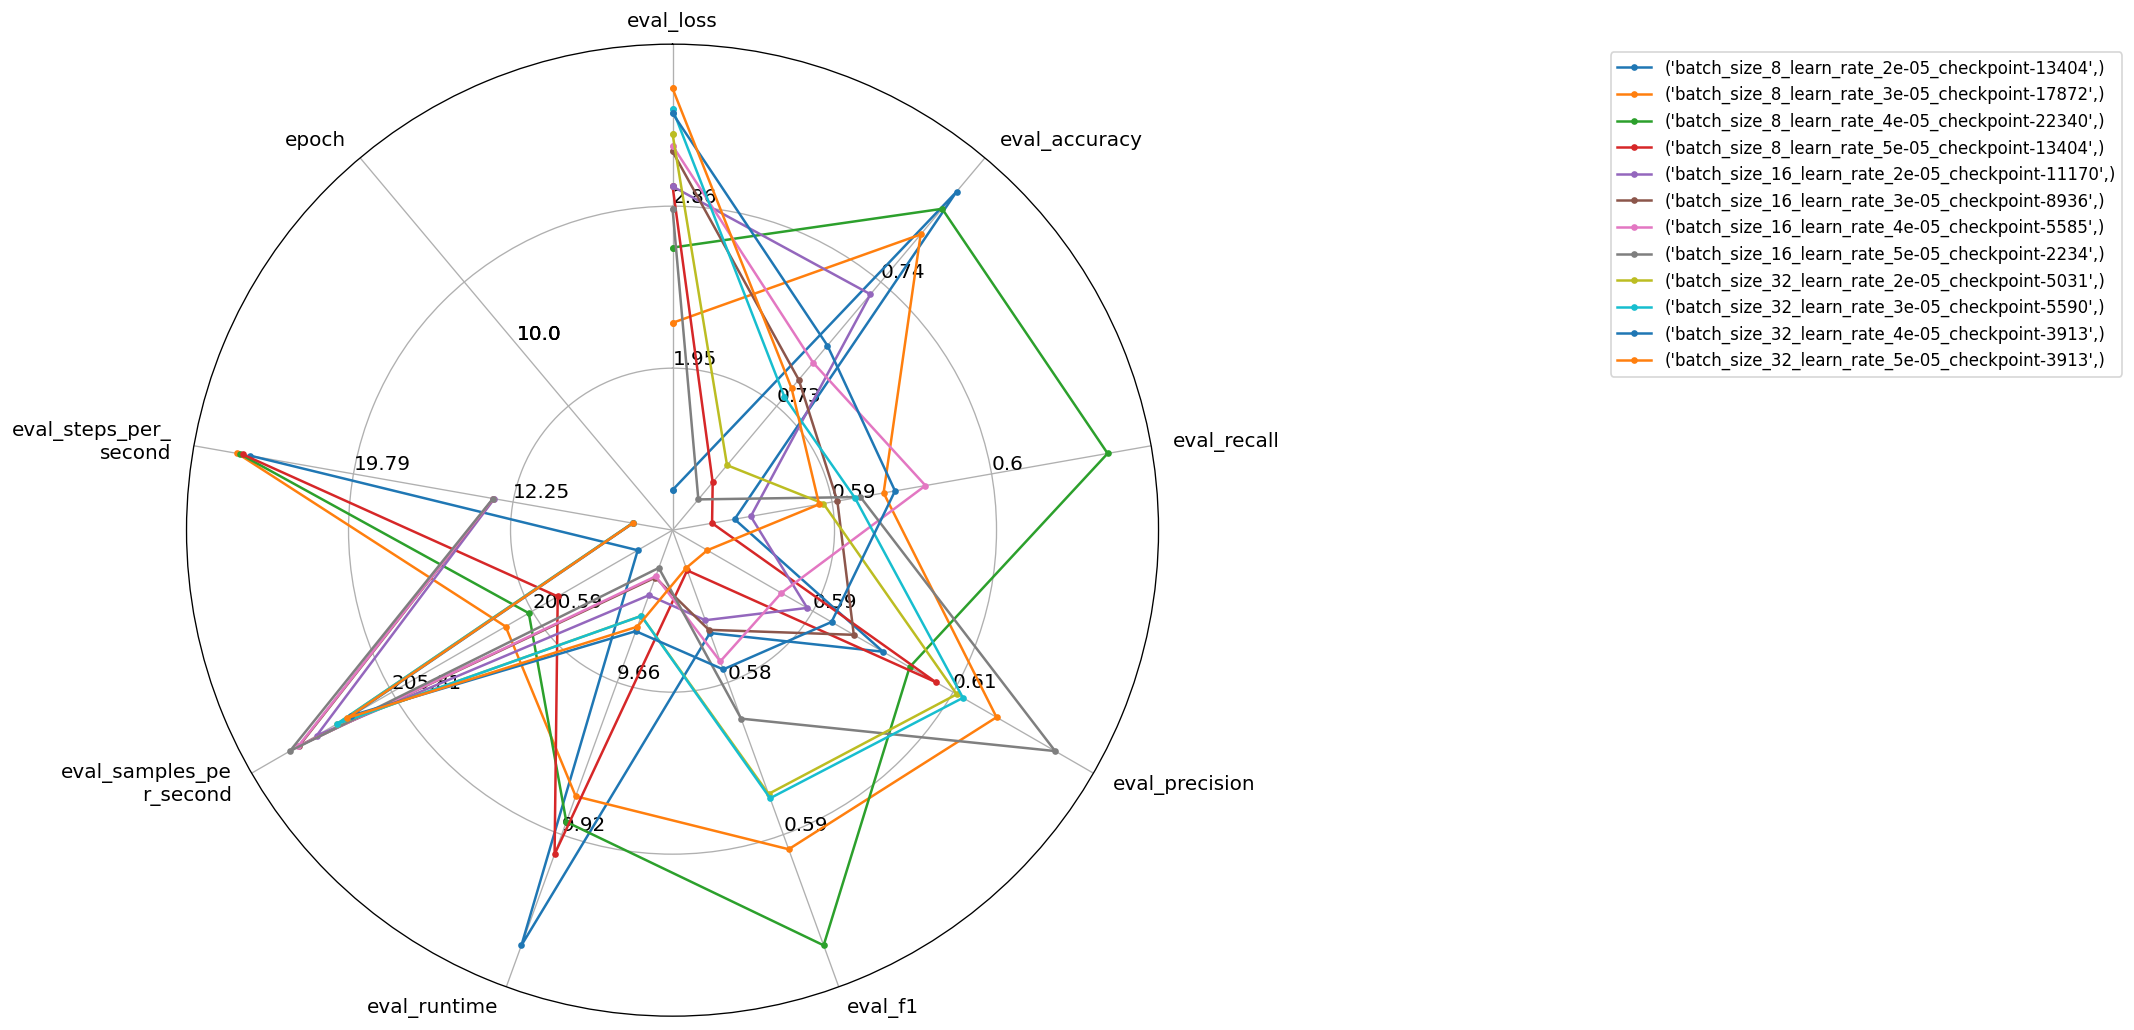

In [11]:
model_names = ["_".join(path.split(sep="/")[-3:]) for path in best_models.keys()]

fig = figure("")
plot = radar_plot(fig=fig, data=list(best_models.values()), model_names=model_names)
plot.show()

In [12]:
# Load model with highest f1/accuracy

COMPARISON_PRECISION = 3
SECONDARY_METRIC = "accuracy"

best_value = 0.0
best_model_path = ""

for model_path, eval_results in best_models.items():
    model_value = np.round(float(eval_results[f"eval_{BEST_METRIC}"]), COMPARISON_PRECISION)
    if model_value > best_value:
        best_value = model_value
        best_model_path = model_path
    elif model_value == best_value:
        # if the main metric is equal to COMPARISON_PRECISION decimal places, then compare secondary metric
        secondary_metric_key = f"eval_{SECONDARY_METRIC}"
        model_secondary_value = np.round(
            float(eval_results[secondary_metric_key]), COMPARISON_PRECISION
        )
        best_secondary_value = np.round(
            float(best_models[best_model_path][secondary_metric_key]), COMPARISON_PRECISION
        )

        if model_secondary_value > best_secondary_value:
            best_model_path = model_path

print(f"Model with highest {BEST_METRIC} score: {best_model_path}\n{best_models[best_model_path]}")
best_model = DistilBertForSequenceClassification.from_pretrained(
    best_model_path, id2label=id2label, label2id=label2id, num_labels=len(labels)
)

Model with highest f1 score: ../models/checkpoints/category_classifier/batch_size_8/learn_rate_4e-05/checkpoint-22340
{'eval_loss': 2.6274983882904053, 'eval_accuracy': 0.74269889224572, 'eval_recall': 0.6134211296656538, 'eval_precision': 0.6036983200956062, 'eval_f1': 0.5999561270604311, 'eval_runtime': 9.8945, 'eval_samples_per_second': 200.719, 'eval_steps_per_second': 25.166, 'epoch': 10.0}


In [ ]:
# Save to ONNX
ort_model = ORTModelForSequenceClassification.from_pretrained(
    best_model_path, export=True, provider=onnx_proxider
)
ort_model.save_pretrained("../models/onnx/category_classifier")

In [ ]:
classifier_pipeline = pipeline(
    "text-classification", model=best_model, tokenizer=tokenizer, device="cpu"
)

In [ ]:
title_examples = []
with open("./files/title_examples.txt", "r") as title_file:
    title_examples = title_file.readlines()

In [15]:
for text_example in title_examples:
    result = classifier_pipeline(text_example)
    predicted_category = result[0][LABEL_COLUMN]
    condfidence = result[0]["score"]

    print(
        f"Input text: {text_example}\nPredicted Category: {predicted_category}\nConfidence: {np.round(condfidence * 100, 2)}%\n"
    )

Input text: Lekker Stoelmassage
Predicted Category: wellbeing_massagists_and_massage_salons
Confidence: 100.0%

Input text: Haar knippen bij u thuis
Predicted Category: hairdressers_and_home_hairdressers
Confidence: 100.0%

Input text: kattenoppas dieren bij u thuis
Predicted Category: animals_cats_care_sitters_lessens
Confidence: 99.99%

Input text: Photoshop les
Predicted Category: photographers
Confidence: 21.03%

Input text: Drone aerial fotografie
Predicted Category: photographers
Confidence: 100.0%

Input text: Computer reparaties
Predicted Category: repair_and_maintenance_pcs_and_gaming_computers
Confidence: 99.91%

Input text: Ontwikkeling van wordpress websites
Predicted Category: web_designers_and_hosting
Confidence: 99.98%

Input text: Huwelijksfotografie
Predicted Category: photographers
Confidence: 100.0%

